## FPL GAFFER TOOL CALLING
This notebook contains experiments with boilerplate tools, showing how FPL Gaffer would chose the tools to call based on prompts from a user during conversations.

In [1]:
from dotenv import load_dotenv
# Load environment variables
load_dotenv()

import os
from typing import List, Literal
from pydantic import BaseModel, Field
from langchain.tools import Tool
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage

In [2]:
# TODO: Use boilerplate functions for tools, assess
# with an LLM to test the tools that would be called
# for different kinds of prompts.

# NOTE: Use proper documentation for the notebook.

In [3]:
# Tool input schemas
class NewsSearchInput(BaseModel):
    """Input schema for the news search tool."""
    query: str = Field(..., description="The search query for news search.")

class PlayerByPositionInput(BaseModel):
    """Input schema for the player by position tool."""
    position: Literal["GKP", "DEF", "MID", "FWD"] = Field(..., description="Position to search for. One of: GK, DEF, MID, FWD.")
    max_price: float = Field(15.0, description="Maximum player price to search for in millions.")


class PlayerDataInput(BaseModel):
    """Input schema for the player data tool."""
    player_names: List[str] = Field(..., description="List of player(s) names to fetch data for.")


class FixturesForRangeInput(BaseModel):
    """Input schema for the fixtures for range tool."""
    num_gameweeks: int = Field(..., description="Number of upcoming gameweeks to fetch fixtures for.")

class UserTeamInfoInput(BaseModel):
    """Input schema for the user team info tool."""
    manager_id: int = Field(..., description="The user's FPL manager ID.")
    gameweek: int = Field(..., description="The current gameweek number to fetch data for.")

In [4]:
# Boilerplate tool functions
def news_search_tool(query: str):
    print(f"[news_search_tool] query: {query}")

def get_user_team_info_tool(manager_id: int, gameweek: int):
    print(f"[get_user_team_info_tool] manager_id={manager_id}, gameweek={gameweek}")

def get_players_by_position_tool(position: Literal["GKP", "DEF", "MID", "FWD"], max_price: float):
    print(f"[get_players_by_position_tool] position={position}, max_price={max_price}")

def get_player_data_tool(player_names: List[str]):
    print(f"[get_player_data_tool] player_names={player_names}")

def get_fixtures_for_range_tool(num_gameweeks: int):
    print(f"[get_fixtures_for_range_tool] num_gameweeks={num_gameweeks}")

# Create tool list
tools = [
    Tool(
        name="news_search_tool",
        description="Search for FPL news, expert analysis, injury updates, press conference information, etc."
                    "Use this when you need information about player/team news, injury, expert opinions, or "
                    "general FPL updates.",
        func=news_search_tool,
        args_schema=NewsSearchInput
    ),
    Tool(
        name="get_user_team_info_tool",
        description="Get comprehensive information about a user's FPL team including squad, transfers, "
                    "and finances. Use this when you need information about the user's team, players, or "
                    "financial situation.",
        func=get_user_team_info_tool,
        args_schema=UserTeamInfoInput
    ),
    Tool(
        name="get_players_by_position_tool",
        description="Get players by position and max price. Use this when you need information for player "
                    "replacements or transfer suggestions based on position and budget.",
        func=get_players_by_position_tool,
        args_schema=PlayerByPositionInput
    ),
    Tool(
        name="get_player_data_tool",
        description="Get detailed player data including stats, form, and injuries. Use this when you need "
                    "information about specific players.",
        func=get_player_data_tool,
        args_schema=PlayerDataInput
    ),
    Tool(
        name="get_fixtures_for_range_tool",
        description="Get fixtures from the current gameweek to the next x gameweeks. Use this when you need "
                    "information about upcoming fixtures or planning for future gameweeks.",
        func=get_fixtures_for_range_tool,
        args_schema=FixturesForRangeInput
    )
]

In [5]:
TOOLS_DESCRIPTION = "\n".join(
    f"{t.name}: {t.description}" for t in tools
)
print(TOOLS_DESCRIPTION)

news_search_tool: Search for FPL news, expert analysis, injury updates, press conference information, etc.Use this when you need information about player/team news, injury, expert opinions, or general FPL updates.
get_user_team_info_tool: Get comprehensive information about a user's FPL team including squad, transfers, and finances. Use this when you need information about the user's team, players, or financial situation.
get_players_by_position_tool: Get players by position and max price. Use this when you need information for player replacements or transfer suggestions based on position and budget.
get_player_data_tool: Get detailed player data including stats, form, and injuries. Use this when you need information about specific players.
get_fixtures_for_range_tool: Get fixtures from the current gameweek to the next x gameweeks. Use this when you need information about upcoming fixtures or planning for future gameweeks.


In [6]:
TOOL_ANALYSIS_PROMPT = f"""
You are an FPL conversational assistant that needs to decide the tools to call to assist the user's query.


Available tools:
{TOOLS_DESCRIPTION}

Determine which tools to call and in what order.

Respond ONLY with a JSON object of the form:
{{"tool_name": "<name>", "arguments": {{ ... }} }}
If no tool fits, respond with:
{{"tool_name": "none", "arguments": {{ "response": "<natural language reply>" }} }}
"""

In [7]:
class ToolResponse(BaseModel):
    tools_to_call: List[str] = Field(..., description="The list of tools to call")

In [8]:
# Initialize llm
llm = ChatGroq(
    api_key=os.environ["GROQ_API_KEY"],
    model="llama-3.3-70b-versatile",
    temperature=0.4
).bind_tools(tools)

In [9]:
def run_query(q: str):
    # prompt = TOOL_ANALYSIS_PROMPT.format(tools_description=TOOLS_DESCRIPTION)
    messages = [TOOL_ANALYSIS_PROMPT, HumanMessage(content=q)]
    result = llm.invoke(messages)

    return result


In [10]:
run_query("Is Salah injured?")

AIMessage(content='{"tool_name": "news_search_tool", "arguments": { "query": "Salah injury" } }', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1109, 'total_tokens': 1133, 'completion_time': 0.044044569, 'prompt_time': 0.089477656, 'queue_time': 0.087254643, 'total_time': 0.133522225}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--37597462-f483-4881-8d02-e93d8852352a-0', usage_metadata={'input_tokens': 1109, 'output_tokens': 24, 'total_tokens': 1133})

In [11]:
response = run_query("Who should I captain this gameweek?")

In [12]:
print(response.content)

{"tool_name": "news_search_tool", "arguments": { "query": "FPL captain tips this gameweek" } }


In [13]:
run_query("Do you suggest I change any player from my team?")

AIMessage(content='{"tool_name": "get_user_team_info_tool", "arguments": { "manager_id": "user_manager_id", "gameweek": "current_gameweek" }}', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1116, 'total_tokens': 1154, 'completion_time': 0.078453459, 'prompt_time': 0.092212897, 'queue_time': 0.086386239, 'total_time': 0.170666356}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--49b8a62a-1ac3-4e32-8234-39a914f71e30-0', usage_metadata={'input_tokens': 1116, 'output_tokens': 38, 'total_tokens': 1154})

In [15]:
response = run_query("Based on fixture difficuly in the next 5 gameweeks, what players do you think I should sell, and what teams can I invest in?")

In [19]:
response.tool_calls

[{'name': 'get_fixtures_for_range_tool',
  'args': {'num_gameweeks': 5},
  'id': '2b8ne2wep',
  'type': 'tool_call'}]

In [20]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2b8ne2wep', 'function': {'arguments': '{"num_gameweeks":5}', 'name': 'get_fixtures_for_range_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1136, 'total_tokens': 1157, 'completion_time': 0.042734522, 'prompt_time': 0.091604286, 'queue_time': 0.088042258, 'total_time': 0.134338808}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--72f8f022-f67c-4acb-996d-2f6d50e90d36-0', tool_calls=[{'name': 'get_fixtures_for_range_tool', 'args': {'num_gameweeks': 5}, 'id': '2b8ne2wep', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1136, 'output_tokens': 21, 'total_tokens': 1157})

In [21]:
from typing import Any, Dict
import json

In [44]:
def call_model(messages):
    response = llm.invoke(messages)
    print(f"Model response: {response}\n")
    return response

In [45]:
# Map tool names to actual functions & schemas
tool_map = {t.name: t for t in tools}

def route_user_query(user_text: str) -> Any:
    """Return either a natural reply or the tool output."""
    messages = [TOOL_ANALYSIS_PROMPT, HumanMessage(content=user_text)]
    raw = call_model(messages)
    content = raw.content if hasattr(raw, "content") else raw["content"]

    # Attempt to parse JSON
    try:
        decision = json.loads(content)
    except json.JSONDecodeError:
        return f"Model returned non-JSON: {content}"

    tool_name = decision.get("tool_name")
    args: Dict = decision.get("arguments", {})

    if tool_name == "none" or tool_name not in tool_map:
        return args.get("response", "I couldn't match a tool.")

    # Validate args with the tool’s Pydantic schema
    schema = tool_map[tool_name].args_schema
    validated = schema(**args)   # raises if missing/invalid

    # Call the underlying function
    return tool_map[tool_name].func(**validated.model_dump())

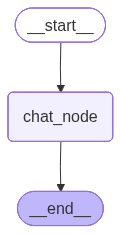

In [46]:
# graph_flow.py
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from IPython.display import display, Image

class State(TypedDict):
    query: str
    reply: Any

graph = StateGraph(State)


def chat_node(state: dict) -> dict:
    user_text = state["query"]
    answer = route_user_query(user_text)
    print(answer)
    return {"reply": answer}

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)


flow = graph.compile()

display(Image(flow.get_graph().draw_mermaid_png()))


In [49]:
result = flow.invoke({"query": "Suggest a midfielder under 6.5 million and tell me who to sell from my team"})
print(">>", result["reply"])

Model response: content='' additional_kwargs={'tool_calls': [{'id': 'av09jy6jj', 'function': {'arguments': '{"max_price":6.5,"position":"MID"}', 'name': 'get_players_by_position_tool'}, 'type': 'function'}, {'id': 'ajvwa5kap', 'function': {'arguments': '{"gameweek":10,"manager_id":12345}', 'name': 'get_user_team_info_tool'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1124, 'total_tokens': 1175, 'completion_time': 0.088877348, 'prompt_time': 0.086366405, 'queue_time': 0.089689929, 'total_time': 0.175243753}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--af725cef-eba8-4985-a0a5-31ad4a5508e5-0' tool_calls=[{'name': 'get_players_by_position_tool', 'args': {'max_price': 6.5, 'position': 'MID'}, 'id': 'av09jy6jj', 'type': 'tool_call'}, {'name': 'get_user_team_info_tool', 'args': {'gameweek': 10, 'manager_id': 12345}, 

In [38]:
print(State)

<class '__main__.State'>


In [ ]:
# TODO: Current experimentations handle only one tool call. Refine to handle multiple tools.